In [68]:
from galileojp.frames import ExperimentFrameGateway
from galileojp.external import concurrent_req_log_as_df, traefik_weight_log_as_df
from galileojp.widgets import experiment_dropdown
import matplotlib.pyplot as plt
import matplotlib.patches as mp
import pandas as pd
import os

In [16]:
def id_by_name(name, filename):
    xp = ExperimentFrameGateway.from_file(filename).experiments()
    return xp[xp['NAME'] == name]['EXP_ID'].iloc[0]

In [17]:
# This function is simply used to convert the log of concurrent clients into something that visualizes well
# When looking at the raw data this should become obvious. There is simply a single timestamp that marks
# the number of active concurrent clients. This value is true until the next value is logged
# A typical visualisation plot would draw a straight line between the points, but since we don't interpolate in truth
# i.e. we don't have 1.5 concurrent clients, only 1 and later on 2, we need to change the data to make the plot accurate
def prepare_concurrent_client_df(filename, from_index, to_index, interval_seconds):
    df = concurrent_req_log_as_df(filename).loc[range(from_index, to_index)]
    df = df.append({ 'timestamp': df.loc[to_index - 1]['timestamp'] + pd.Timedelta(str(interval_seconds) + "s"), 'concurrent_clients': 36}, ignore_index=True)
    df = df.reset_index(drop=True)
    int_df = df.copy()
    i = 0
    lastval = 0
    for index, row in df.iterrows():
        if not i == 0:
            int_df = int_df.append({ "timestamp": row['timestamp'] - pd.Timedelta("1ns"), "concurrent_clients": lastval}, ignore_index=True)
        i += 1
        lastval = row['concurrent_clients']
    int_df = int_df.sort_values(by=['timestamp'])
    int_df = int_df.reset_index(drop=True)
    return int_df

In [18]:

def make_plot(host, title, base_df, conc_df):
    host.set_title(title)
    par1 = host.twinx()
    par2 = host.twinx()
    par3 = host.twinx()

    host.set_ylim(0, 6)
    par1.set_ylim(0, 110)
    par2.set_ylim(0, 110)
    par3.set_ylim(0, 1000)

    host.set_xlabel("Time")
    host.set_ylabel("Concurrent Requests")
    par1.set_ylabel("CPU Utilization %")
    par2.set_ylabel("RAM Utilization %")
    par3.set_ylabel("Response Time")

    host.set_zorder(1000)
    host.patch.set_visible(False)
    par1.set_zorder(10)
    par2.set_zorder(10)
    par3.set_zorder(1)

    c1 = 'black'
    c2 = 'silver'
    c3 = 'tab:red'
    c4 = 'tab:blue'

    color1 = plt.cm.viridis(0)
    color2 = plt.cm.viridis(0.5)
    color3 = plt.cm.viridis(.9)

    p1, = host.plot(conc_df['timestamp'], conc_df['concurrent_clients'], color=c1, zorder=1000)
    p2, = par1.plot(base_df['sent'], base_df['cpu'], color=c3, zorder=2)
    p3, = par2.plot(base_df['sent'], base_df['ram'], color=c4, zorder=2)
    p4, = par3.plot(base_df['sent'], base_df['rtt'], color=c2, zorder=1)

    par1.spines['right'].set_position(('outward', 45))
    par2.spines['right'].set_position(('outward', 90))


    host.yaxis.label.set_color(p1.get_color())
    par1.yaxis.label.set_color(p2.get_color())
    par2.yaxis.label.set_color(p3.get_color())

    par2.xaxis.set_ticks([])
    par3.xaxis.set_ticks([])




### data files of the weight convergence experiments

In [23]:
base_path = '../data/weight_convergence'
db_path = base_path + '/weight_convergence.sqlite'
weight_path = base_path + '/weight_logs/weights.log'
edge_weight_path = base_path + '/weight_logs/edge_weights.log'
rr_log_path = base_path + '/concurrency_logs/rr.log'
lrt_log_path = base_path + '/concurrency_logs/lrt.log'
edge_rr_log_path = base_path + '/concurrency_logs/edge_rr.log'
edge_lrt_log_path = base_path + '/concurrency_logs/edge_lrt.log'


In [24]:
w1s = '10.0.0.6:9081'
w2s = '10.0.0.8:9081'
w3m = '10.0.0.9:9081'
w4l = '10.0.0.7:9081'
w5l = '10.0.0.11:9081'

In [25]:
def load_weight_log(path):
    weights = traefik_weight_log_as_df(path, 'pdf')
    weights = weights.rename(columns={w1s:'w1s', w2s:'w2s', w3m:'w3m', w4l:'w4l',w5l:'w5l'})
    return weights
    
weight_log = load_weight_log(weight_path)
edge_weight_log = load_weight_log(edge_weight_path)


lrt_concurrent = prepare_concurrent_client_df(lrt_log_path, 0, 5, 120)
rr_concurrent = prepare_concurrent_client_df(rr_log_path, 0, 5, 120)
edge_lrt_concurrent = prepare_concurrent_client_df(edge_lrt_log_path, 0, 5, 120)
edge_rr_concurrent = prepare_concurrent_client_df(edge_rr_log_path, 0, 5, 120)


In [26]:
gw = ExperimentFrameGateway.from_file(db_path)
rr_df = gw.traces(id_by_name('weight_convergence_pdf_rr', db_path))
lrt_df = gw.traces(id_by_name('weight_convergence_pdf_lrt', db_path))
edge_rr_df = gw.traces(id_by_name('edge_weight_convergence_pdf_rr', db_path))
edge_lrt_df = gw.traces(id_by_name('edge_weight_convergence_pdf_lrt', db_path))

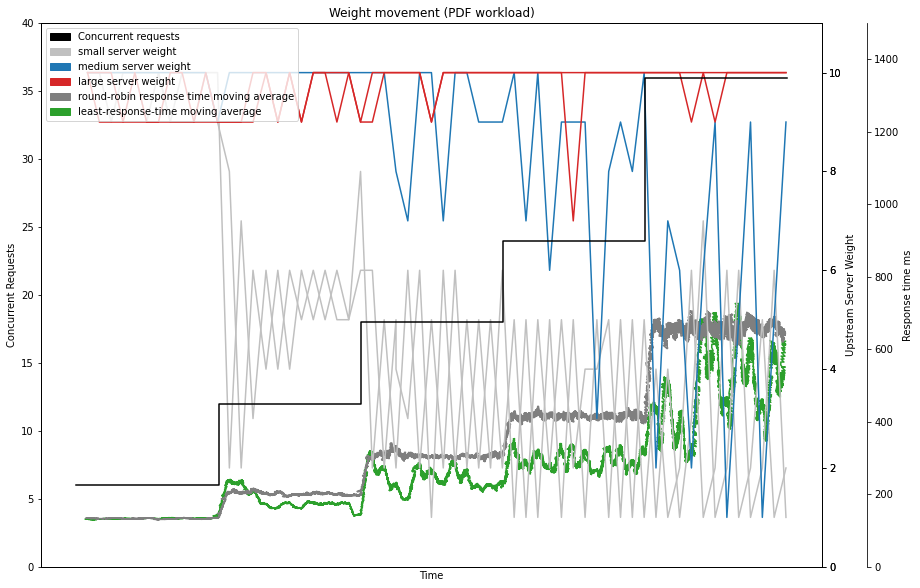

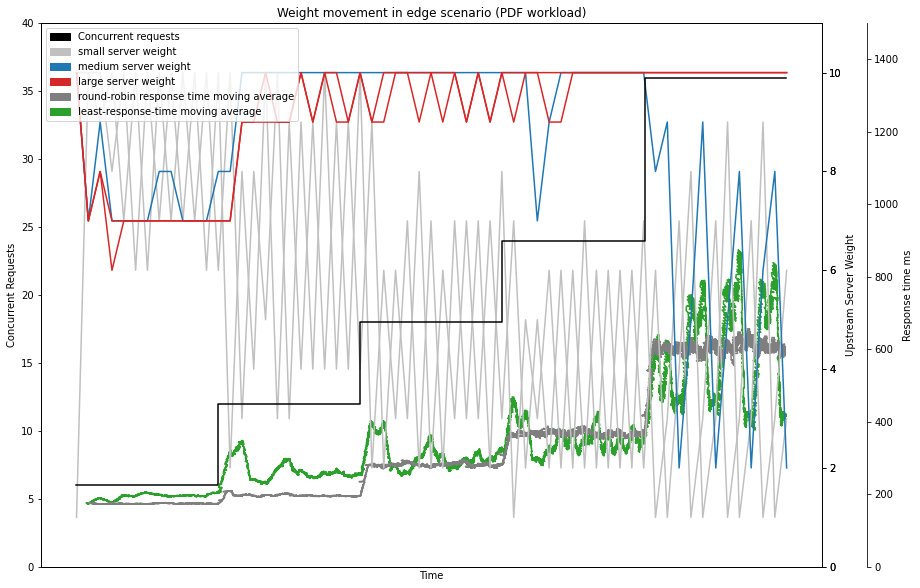

In [73]:
def draw_weight_convergence(host, title, weight_df, trace_df, conc_df, other_df):
    # Cut the weight log down to size, since it doesn't start or end based on galileo experiment triggers
    weight_df = weight_df[weight_df.index >= conc_df['timestamp'].min()]
    modified_traces = rr_df.copy()
    rr_sent_min = other_df['SENT'].min()
    lrt_sent_min = trace_df['SENT'].min()
    delta = 0
    if rr_sent_min > lrt_sent_min:
        delta = rr_sent_min - lrt_sent_min
        other_df['SENT'] = other_df['SENT'].apply(lambda x: x - delta)
    else:
        delta = lrt_sent_min - rr_sent_min
        other_df['SENT'] = other_df['SENT'].apply(lambda x: x + delta)
   
    
    host.set_title(title)
    par1 = host.twinx()
    par2 = host.twinx()
    par3 = host.twinx()
    par4 = host.twinx()

    host.set_ylim(0, 40)
    par1.set_ylim(0, 11)
    par2.set_ylim(0, 11)
    par3.set_ylim(0, 11)
    par4.set_ylim(0, 1500)

    host.set_xlabel("Time")
    host.set_ylabel("Concurrent Requests")
    par1.set_ylabel("Upstream Server Weight")
#     par2.set_ylabel("RAM Utilization %")
#     par3.set_ylabel("Response Time")
    par4.set_ylabel("Response time ms")

    host.set_zorder(1000)
    host.patch.set_visible(False)
    par1.set_zorder(10)
    par2.set_zorder(10)
    par3.set_zorder(1)

    c1 = 'black'
    c2 = 'silver'
    c3 = 'tab:blue'
    c4 = 'tab:red'
    c5 = 'tab:green'
    c6 = 'tab:grey'
    
    conc_patch = mp.Patch(color=c1, label='Concurrent requests')
    s_patch = mp.Patch(color=c2, label='small server weight')
    m_patch = mp.Patch(color=c3, label='medium server weight')
    l_patch = mp.Patch(color=c4, label='large server weight')
    rr_patch = mp.Patch(color=c6, label='round-robin response time moving average')
    lrt_patch = mp.Patch(color=c5, label='least-response-time moving average')
    host.legend(handles=[conc_patch, s_patch, m_patch, l_patch, rr_patch, lrt_patch])

    color1 = plt.cm.viridis(0)
    color2 = plt.cm.viridis(0.5)
    color3 = plt.cm.viridis(.9)

#     p1, = host.plot(conc_df['timestamp'], conc_df['concurrent_clients'], color=c1, zorder=1000)
    p1, = host.plot(conc_df['timestamp'], conc_df['concurrent_clients'], color=c1, zorder=1000)
    p2, = par1.plot(weight_df.index, weight_df['w1s'], color=c2)
    par1.plot(weight_df.index, weight_df['w2s'], color=c2)
    p2, = par1.plot(weight_df.index, weight_df['w3m'], color=c3)
    p3, = par2.plot(weight_df.index, weight_df['w4l'], color=c4, zorder=2)
    par2.plot(weight_df.index, weight_df['w5l'], color=c4, zorder=2)
    p4, = par4.plot(trace_df['SENT'], trace_df['RTT'].rolling(300).mean(), color=c5)
    par4.plot(other_df['SENT'], other_df['RTT'].rolling(300).mean(), color=c6)
#     p4, = par3.plot(base_df['sent'], base_df['rtt'], color=c2, zorder=1)

#     par1.spines['right'].set_position(('outward', 45))
#     par2.spines['right'].set_position(('outward', 90))
    par4.spines['right'].set_position(('outward', 45))

    host.yaxis.label.set_color(p1.get_color())
#     par1.yaxis.label.set_color(p2.get_color())
#     par2.yaxis.label.set_color(p3.get_color())

    par2.xaxis.set_ticks([])
    par2.yaxis.set_ticks([])
    par3.xaxis.set_ticks([])
#     par3.yaxis.set_tricks([])

    
    
fig_normal, host_normal = plt.subplots(figsize=(14, 10))
fig_edge, host_edge = plt.subplots(figsize=(14, 10))
draw_weight_convergence(host_edge, 'Weight movement in edge scenario (PDF workload)', edge_weight_log, edge_lrt_df, edge_lrt_concurrent, edge_rr_df)
draw_weight_convergence(host_normal, 'Weight movement (PDF workload)', weight_log, lrt_df, lrt_concurrent, rr_df)

NameError: name 'small_log_path' is not defined

NameError: name 'small_db_path' is not defined